<a href="https://www.kaggle.com/code/fiftythirtyfour/house-prices?scriptVersionId=135861659" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [3]:
df.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [4]:
num = [x for x in df.columns if df.dtypes[x] in ('int64', 'float')]
cat = [x for x in df.columns if df.dtypes[x] == 'object']
target = 'SalePrice'
num.remove(target)

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2, random_state=0)

# Explore

In [6]:
corr = train.corr(numeric_only=True)
corr[target].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790636
GrLivArea        0.721707
GarageCars       0.660927
GarageArea       0.646603
TotalBsmtSF      0.635535
1stFlrSF         0.620740
FullBath         0.578134
TotRmsAbvGrd     0.542658
YearBuilt        0.521242
YearRemodAdd     0.517822
GarageYrBlt      0.494154
MasVnrArea       0.493482
Fireplaces       0.470320
BsmtFinSF1       0.401390
LotFrontage      0.360274
OpenPorchSF      0.320193
2ndFlrSF         0.320141
WoodDeckSF       0.311813
HalfBath         0.283762
LotArea          0.252766
BsmtFullBath     0.226432
BsmtUnfSF        0.206736
BedroomAbvGr     0.182258
ScreenPorch      0.096740
3SsnPorch        0.057561
MoSold           0.041369
PoolArea         0.027441
BsmtHalfBath    -0.010994
Id              -0.017389
BsmtFinSF2      -0.020622
LowQualFinSF    -0.023128
MiscVal         -0.024750
YrSold          -0.045628
OverallCond     -0.053643
MSSubClass      -0.084312
EnclosedPorch   -0.129519
KitchenAbvGr    -0.136104
Name: SalePr

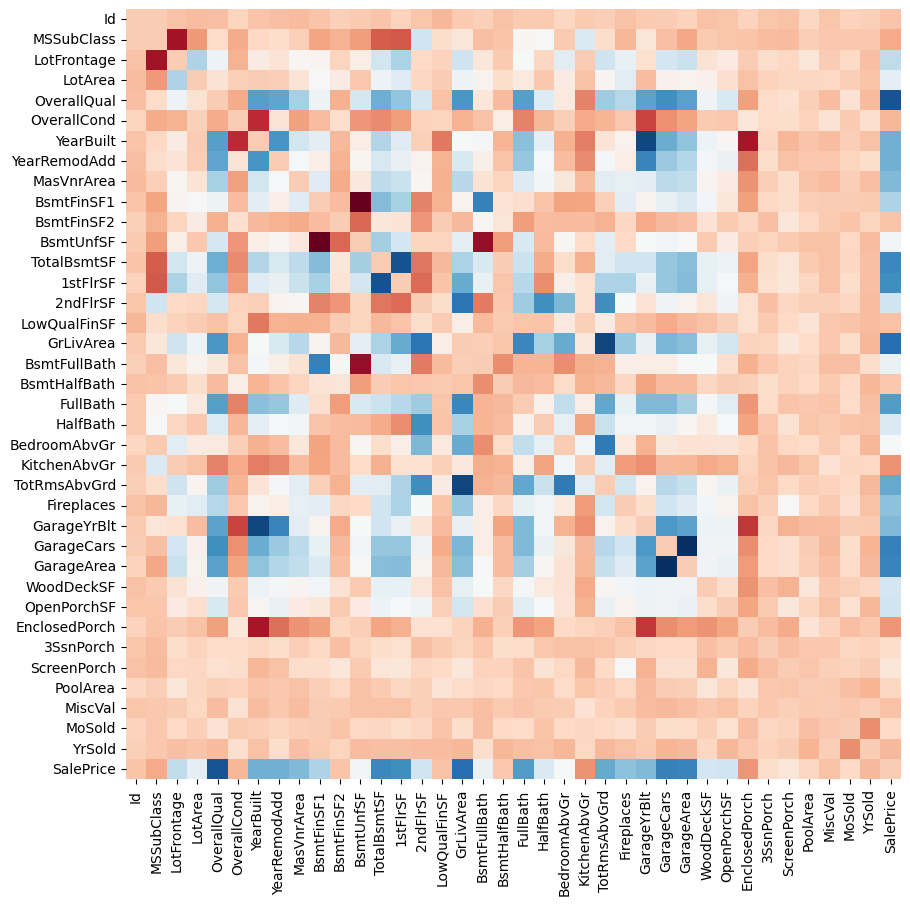

In [7]:
np.fill_diagonal(corr.values, 0)
plt.subplots(figsize=(10, 10))
sns.heatmap(corr, cmap='RdBu', cbar=False);

In [8]:
train[num].isnull().sum().sort_values(ascending=False)

LotFrontage      212
GarageYrBlt       58
MasVnrArea         6
Id                 0
WoodDeckSF         0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageCars         0
GarageArea         0
EnclosedPorch      0
OpenPorchSF        0
HalfBath           0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
BedroomAbvGr       0
BsmtHalfBath       0
FullBath           0
BsmtFinSF2         0
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
BsmtFinSF1         0
BsmtUnfSF          0
MSSubClass         0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
YrSold             0
dtype: int64

In [9]:
train[cat].isnull().sum().sort_values(ascending=False)

PoolQC           1164
MiscFeature      1119
Alley            1097
Fence             954
FireplaceQu       551
GarageType         58
GarageCond         58
GarageQual         58
GarageFinish       58
BsmtFinType2       29
BsmtFinType1       28
BsmtQual           28
BsmtExposure       28
BsmtCond           28
MasVnrType          6
Electrical          1
Functional          0
KitchenQual         0
CentralAir          0
HeatingQC           0
Heating             0
PavedDrive          0
SaleType            0
MSZoning            0
Street              0
Condition2          0
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
BldgType            0
Foundation          0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
ExterQual           0
ExterCond           0
SaleCondition       0
dtype: int64

# Pipeline

In [10]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataSelect(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = attributes
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attributes]

In [12]:
num_pp = Pipeline([
    ('dataselect', DataSelect(num))
    , ('impute', SimpleImputer(strategy='median'))
    , ('scaler', StandardScaler())
])

cat_pp = Pipeline([
    ('dataselect', DataSelect(cat))
    , ('encoder', OneHotEncoder(sparse_output=False))
])

pipe = FeatureUnion([
    ('num', num_pp)
#     , ('cat', cat_pp)
])

pipe.fit(train)
train_pre = pipe.transform(train)
test_pre = pipe.transform(test)

# Model Selection

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

In [14]:
lin = LinearRegression()
lin.fit(train_pre, train[target])
np.sqrt(-cross_val_score(lin, train_pre, train[target], scoring='neg_mean_squared_error')).mean()

32051.816164161304

In [15]:
rfr = RandomForestRegressor(random_state=0)
rfr.fit(train_pre, train[target])
np.sqrt(-cross_val_score(rfr, train_pre, train[target], scoring='neg_mean_squared_error')).mean()

29464.261089446296

In [16]:
dtr = DecisionTreeRegressor(random_state=0)
dtr.fit(train_pre, train[target])
np.sqrt(-cross_val_score(dtr, train_pre, train[target], scoring='neg_mean_squared_error')).mean()

42233.40878386205

In [17]:
model_base = rfr

# Validation

In [18]:
np.sqrt(-cross_val_score(model_base, test_pre, test[target], scoring='neg_mean_squared_error')).mean()

40747.26133269096

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
model_base.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [21]:
params = {
    'random_state': [0]
    , 'max_features': [4, 6, 8]
    , 'n_estimators': [100, 200, 300]
}
grd = GridSearchCV(rfr, param_grid=params, scoring='neg_mean_squared_error')

In [22]:
grd.fit(train_pre, train[target])

GridSearchCV(estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_features': [4, 6, 8],
                         'n_estimators': [100, 200, 300], 'random_state': [0]},
             scoring='neg_mean_squared_error')

In [23]:
grd.best_params_

{'max_features': 6, 'n_estimators': 300, 'random_state': 0}

In [24]:
model_tune = RandomForestRegressor(random_state=0, max_features=6, n_estimators=300)

In [25]:
np.sqrt(-cross_val_score(model_tune, train_pre, train[target], scoring='neg_mean_squared_error')).mean()

28581.932624544133

In [26]:
np.sqrt(-cross_val_score(model_tune, test_pre, test[target], scoring='neg_mean_squared_error')).mean()

40290.82792823954

In [27]:
model_tune.fit(train_pre, train[target])

RandomForestRegressor(max_features=6, n_estimators=300, random_state=0)

# Submission

In [28]:
samp = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
pd.DataFrame({
    'Id': samp['Id']
    , 'SalePrice': model_tune.predict(pipe.transform(samp))
}).to_csv('submission.csv', index=False)

# Notes
- you are struggling with Model Selection and Validation sections. Start here always.
- you are already good with Loading data, base Exploration and Pipeline